[ESP] Generation 0: avg reward = -475.83, best = -94.24
[ESP] Generation 1: avg reward = -487.37, best = -80.73
[ESP] Generation 2: avg reward = -476.62, best = -124.40
[ESP] Generation 3: avg reward = -478.03, best = -96.82
[ESP] Generation 4: avg reward = -590.89, best = -128.44
[ESP] Generation 5: avg reward = -463.83, best = -121.44
[ESP] Generation 6: avg reward = -479.47, best = -116.39
[ESP] Generation 7: avg reward = -505.55, best = -92.76
[ESP] Generation 8: avg reward = -498.58, best = -134.12
[ESP] Generation 9: avg reward = -541.33, best = -166.14
[ESP] Generation 10: avg reward = -465.09, best = -107.86
[ESP] Generation 11: avg reward = -444.65, best = -110.47
[ESP] Generation 12: avg reward = -457.90, best = -91.89
[ESP] Generation 13: avg reward = -465.17, best = -97.46
[ESP] Generation 14: avg reward = -375.73, best = -80.16
[ESP] Generation 15: avg reward = -409.44, best = -67.27
[ESP] Generation 16: avg reward = -443.17, best = -96.81
[ESP] Generation 17: avg reward =

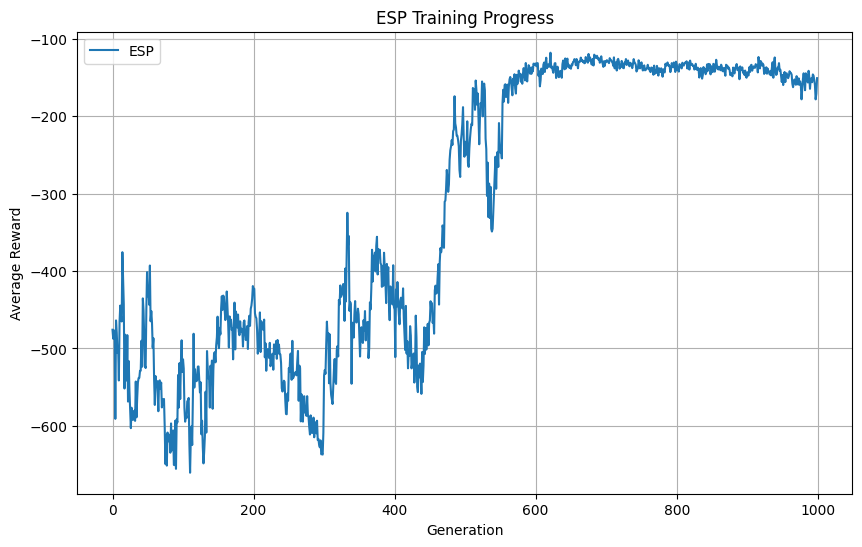

In [3]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import random
from copy import deepcopy
import networkx as nx
from matplotlib.lines import Line2D
import imageio
from PIL import Image, ImageDraw, ImageFont

# Install required packages (you can run this in Jupyter notebook or Colab)
# !pip install swig
# !pip install "gymnasium[box2d]"
# !pip install imageio pillow matplotlib networkx

# Hyperparameters
INPUT_SIZE = 8
HIDDEN_SIZE = 16
OUTPUT_SIZE = 4
POP_SIZE = 50
GENERATIONS = 1000
EPISODES_PER_NETWORK = 3
MUTATION_RATE = 0.2
ELITE_RATIO = 0.2
OUTPUT_MUTATION_STRENGTH = 0.02

# Colors for visualization
INPUT_COLOR = '#FF9999'
HIDDEN_COLOR = '#99CCFF'
OUTPUT_COLOR = '#99FF99'
POSITIVE_EDGE_COLOR = '#FF6666'
NEGATIVE_EDGE_COLOR = '#6666FF'

def relu(x):
    return np.maximum(0, x)

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

class NeuronGenome:
    def __init__(self, input_size):
        self.weights = np.random.randn(input_size)
        self.bias = np.random.randn()

    def mutate(self):
        if np.random.rand() < MUTATION_RATE:
            self.weights += np.random.randn(*self.weights.shape) * 0.1
            self.bias += np.random.randn() * 0.1

    def copy(self):
        copied = NeuronGenome(len(self.weights))
        copied.weights = np.copy(self.weights)
        copied.bias = self.bias
        return copied

    def __getstate__(self):
        return {'weights': self.weights, 'bias': self.bias}

    def __setstate__(self, state):
        self.weights = state['weights']
        self.bias = state['bias']

class ESPNetwork:
    def __init__(self, hidden_neurons):
        self.hidden_neurons = hidden_neurons
        self.output_weights = np.random.randn(HIDDEN_SIZE, OUTPUT_SIZE)

    def forward(self, x):
        h = relu([np.dot(n.weights, x) + n.bias for n in self.hidden_neurons])
        return softmax(np.dot(h, self.output_weights))

def evaluate(network, env_name="LunarLander-v3"):
    env = gym.make(env_name)
    total_reward = 0
    for _ in range(EPISODES_PER_NETWORK):
        obs, _ = env.reset()
        done = False
        while not done:
            action_probs = network.forward(obs)
            action = np.argmax(action_probs)
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward
    env.close()
    return total_reward / EPISODES_PER_NETWORK

def visualize_network(subpops, output_weights, generation, filename=None):
    sample_indices = [random.randint(0, POP_SIZE-1) for _ in range(HIDDEN_SIZE)]
    hidden_neurons = [subpops[i][sample_indices[i]] for i in range(HIDDEN_SIZE)]
    sample_output_weights = output_weights[random.randint(0, POP_SIZE-1)]

    plt.figure(figsize=(15, 10))
    G = nx.DiGraph()

    # Add nodes
    for i in range(INPUT_SIZE):
        G.add_node(f'I{i}', layer=0, color=INPUT_COLOR)
    for i in range(HIDDEN_SIZE):
        G.add_node(f'H{i}', layer=1, color=HIDDEN_COLOR)
    for i in range(OUTPUT_SIZE):
        G.add_node(f'O{i}', layer=2, color=OUTPUT_COLOR)

    # Add edges
    for hi in range(HIDDEN_SIZE):
        neuron = hidden_neurons[hi]
        for ii in range(INPUT_SIZE):
            weight = neuron.weights[ii]
            color = POSITIVE_EDGE_COLOR if weight > 0 else NEGATIVE_EDGE_COLOR
            G.add_edge(f'I{ii}', f'H{hi}', weight=weight, color=color)

    for hi in range(HIDDEN_SIZE):
        for oi in range(OUTPUT_SIZE):
            weight = sample_output_weights[hi][oi]
            color = POSITIVE_EDGE_COLOR if weight > 0 else NEGATIVE_EDGE_COLOR
            G.add_edge(f'H{hi}', f'O{oi}', weight=weight, color=color)

    # Positioning
    pos = {}
    layer_width = 5
    input_y = np.linspace(0, layer_width, INPUT_SIZE)
    hidden_y = np.linspace(0, layer_width, HIDDEN_SIZE)
    output_y = np.linspace(0, layer_width, OUTPUT_SIZE)

    for i in range(INPUT_SIZE):
        pos[f'I{i}'] = (0, input_y[i])
    for i in range(HIDDEN_SIZE):
        pos[f'H{i}'] = (1, hidden_y[i])
    for i in range(OUTPUT_SIZE):
        pos[f'O{i}'] = (2, output_y[i])

    node_colors = [G.nodes[n]['color'] for n in G.nodes()]
    edge_colors = [G.edges[e]['color'] for e in G.edges()]
    edge_widths = [abs(G.edges[e]['weight']) * 2 for e in G.edges()]

    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=800)
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths, arrows=False)
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Input', markerfacecolor=INPUT_COLOR, markersize=10),
        Line2D([0], [0], marker='o', color='w', label='Hidden', markerfacecolor=HIDDEN_COLOR, markersize=10),
        Line2D([0], [0], marker='o', color='w', label='Output', markerfacecolor=OUTPUT_COLOR, markersize=10),
        Line2D([0], [0], color=POSITIVE_EDGE_COLOR, lw=2, label='Positive Weight'),
        Line2D([0], [0], color=NEGATIVE_EDGE_COLOR, lw=2, label='Negative Weight')
    ]
    plt.legend(handles=legend_elements, loc='upper right')
    plt.title(f"Network Structure at Generation {generation}")
    plt.axis('off')

    if filename:
        plt.savefig(filename)
    plt.close()

def record_episode_as_gif(network, filename="best_individual_episode.gif", env_name="LunarLander-v3"):
    frames = []
    env = gym.make(env_name, render_mode="rgb_array")
    obs, _ = env.reset()
    done = False

    while not done:
        frame = env.render()
        frames.append(Image.fromarray(frame))
        action_probs = network.forward(obs)
        action = np.argmax(action_probs)
        obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

    env.close()

    draw = ImageDraw.Draw(frames[0])
    try:
        font = ImageFont.truetype("arial.ttf", 24)
    except:
        font = ImageFont.load_default()
    draw.text((10, 10), "Best Individual Performance", font=font, fill=(255, 255, 255))

    frames[0].save(filename, save_all=True, append_images=frames[1:], duration=50, loop=0, optimize=True, quality=20)

def run_esp():
    subpops = [[NeuronGenome(INPUT_SIZE) for _ in range(POP_SIZE)] for _ in range(HIDDEN_SIZE)]
    output_weight_pool = [np.random.randn(HIDDEN_SIZE, OUTPUT_SIZE) for _ in range(POP_SIZE)]
    best_scores = []

    # Directories to store results
    os.makedirs("network_visualizations", exist_ok=True)
    os.makedirs("episode_recordings", exist_ok=True)

    networks_to_visualize = {}

    for gen in range(GENERATIONS):
        networks = []
        fitnesses = []

        for _ in range(POP_SIZE):
            indices = [random.randint(0, POP_SIZE-1) for _ in range(HIDDEN_SIZE)]
            hidden_neurons = [subpops[i][idx] for i, idx in enumerate(indices)]
            network = ESPNetwork(hidden_neurons)
            network.output_weights = output_weight_pool[random.randint(0, POP_SIZE-1)]
            reward = evaluate(network)
            networks.append((network, indices))
            fitnesses.append(reward)

        usage = [[0]*POP_SIZE for _ in range(HIDDEN_SIZE)]
        rewards = [[0.0]*POP_SIZE for _ in range(HIDDEN_SIZE)]

        for idx, ((network, indices), reward) in enumerate(zip(networks, fitnesses)):
            for i, n_idx in enumerate(indices):
                usage[i][n_idx] += 1
                rewards[i][n_idx] += reward

        num_elites = int(POP_SIZE * ELITE_RATIO)

        # Update hidden neuron subpopulations
        for i in range(HIDDEN_SIZE):
            avg_rewards = [rewards[i][j] / (usage[i][j] or 1) for j in range(POP_SIZE)]
            ranked = sorted(zip(avg_rewards, subpops[i]), key=lambda x: x[0], reverse=True)
            elites = [g.copy() for _, g in ranked[:num_elites]]
            next_pop = elites[:]
            while len(next_pop) < POP_SIZE:
                parent = random.choice(elites)
                offspring = mutate_copy_neuron(parent)
                next_pop.append(offspring)
            subpops[i] = next_pop

        # Update output weights
        sorted_fitness = np.argsort(fitnesses)[::-1]
        elite_outputs = [output_weight_pool[i] for i in sorted_fitness[:num_elites]]

        next_outputs = [w.copy() for w in elite_outputs]
        for _ in range(POP_SIZE - num_elites):
            base = random.choice(elite_outputs)
            mutated = base + np.random.randn(*base.shape) * OUTPUT_MUTATION_STRENGTH
            next_outputs.append(mutated)
        output_weight_pool = next_outputs

        mean_score = np.mean(fitnesses)
        best_score = np.max(fitnesses)
        best_scores.append(mean_score)
        print(f"[ESP] Generation {gen}: avg reward = {mean_score:.2f}, best = {best_score:.2f}")

        # Store networks for visualization
        if gen == 0:
            networks_to_visualize['gen1'] = (deepcopy(subpops), deepcopy(output_weight_pool))
        elif gen == 499:
            networks_to_visualize['gen500'] = (deepcopy(subpops), deepcopy(output_weight_pool))
        elif gen == 999:
            networks_to_visualize['gen1000'] = (deepcopy(subpops), deepcopy(output_weight_pool))

    # Save visualizations
    visualize_network(*networks_to_visualize['gen1'], generation=1,
                      filename="network_visualizations/network_gen1.png")
    visualize_network(*networks_to_visualize['gen500'], generation=500,
                      filename="network_visualizations/network_gen500.png")
    visualize_network(*networks_to_visualize['gen1000'], generation=1000,
                      filename="network_visualizations/network_gen1000.png")

    # Record best individual
    best_idx = np.argmax(fitnesses)
    best_hidden_indices = networks[best_idx][1]
    best_hidden_neurons = [subpops[i][best_hidden_indices[i]] for i in range(HIDDEN_SIZE)]
    best_network = ESPNetwork(best_hidden_neurons)
    best_network.output_weights = output_weight_pool[best_idx]

    record_episode_as_gif(best_network, filename="episode_recordings/best_individual_episode.gif")

    return subpops, output_weight_pool, best_scores

def mutate_copy_neuron(neuron):
    new_neuron = neuron.copy()
    new_neuron.mutate()
    return new_neuron

def save_model(subpops, output_weights, filename):
    with open(filename, 'wb') as f:
        pickle.dump((subpops, output_weights), f)

def load_model(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

def plot_rewards(esp_scores):
    plt.figure(figsize=(10, 6))
    plt.plot(esp_scores, label='ESP')
    plt.xlabel("Generation")
    plt.ylabel("Average Reward")
    plt.title("ESP Training Progress")
    plt.grid(True)
    plt.legend()
    plt.savefig("rewards.png")
    plt.show()

if __name__ == '__main__':
    subpops, output_weights, esp_scores = run_esp()
    save_model(subpops, output_weights, "esp_model.pkl")
    plot_rewards(esp_scores)

In [4]:
import os
print(os.listdir())
import os
print(os.listdir())

['.config', 'episode_recordings', 'rewards.png', 'network_visualizations', 'esp_model.pkl', 'sample_data']
['.config', 'episode_recordings', 'rewards.png', 'network_visualizations', 'esp_model.pkl', 'sample_data']


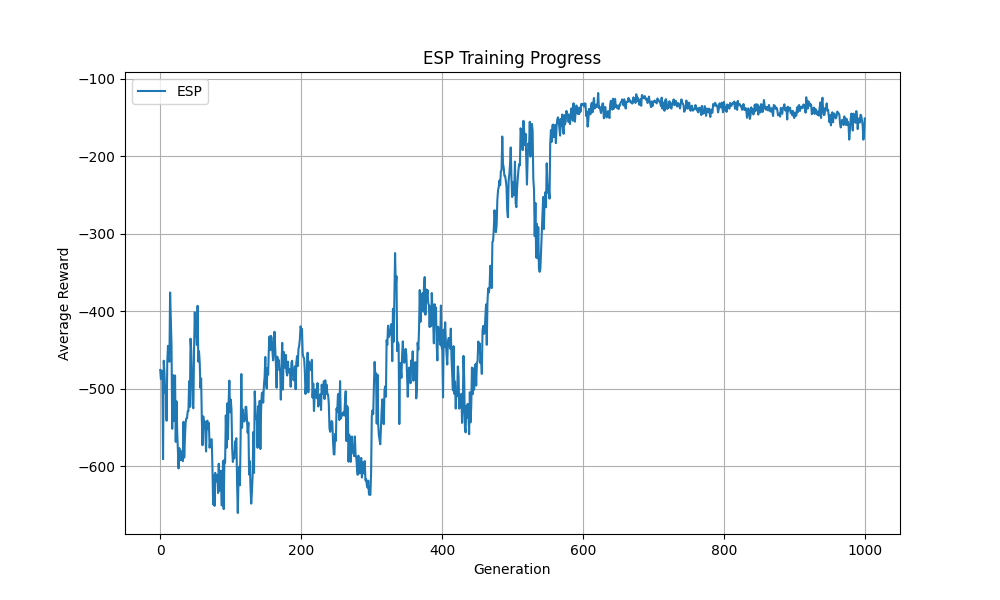

In [5]:
from IPython.display import display, Image
display(Image(filename='rewards.png'))

In [6]:
display(Image(filename='network_visualizations/network_gen1.png'))
display(Image(filename='network_visualizations/network_gen500.png'))
display(Image(filename='network_visualizations/network_gen1000.png'))

Output hidden; open in https://colab.research.google.com to view.

In [28]:
import os

gif_path = "episode_recordings/best_individual_episode.gif"
print(f"File exists: {os.path.exists(gif_path)}")
print(f"File size: {os.path.getsize(gif_path)} bytes") # 显示文件大小，以字节为单位
def record_episode_as_gif(network, filename="best_individual_episode.gif", env_name="LunarLander-v3"):
    frames = []
    env = gym.make(env_name, render_mode="rgb_array")
    obs, _ = env.reset()
    done = False

    while not done:
        frame = env.render()
        if frame is None:
            print("⚠️ Frame is None. Episode may have failed.")
            break
        frames.append(Image.fromarray(frame))
        action_probs = network.forward(obs)
        action = np.argmax(action_probs)
        obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

    env.close()

    if not frames:
        print("⚠️ No frames recorded. Episode may have failed.")
        return

    try:
        frames[0].save(
            filename,
            save_all=True,
            append_images=frames[1:],
            duration=50,
            loop=0,
            optimize=True,
            quality=20
        )
        print(f"✅ GIF saved to {filename}")
    except Exception as e:
        print(f"❌ Failed to save GIF: {e}")
        import imageio.v2 as imageio

gif_path = "episode_recordings/best_individual_episode.gif"

try:
    gif = imageio.mimread(gif_path)
    if gif:
        print("🎉 GIF appears to be valid and readable.")
    else:
        print("⚠️ GIF seems to be empty or corrupted.")
except Exception as e:
    print(f"❌ Error reading GIF: {e}")
    from IPython.display import HTML

HTML('<img src="episode_recordings/best_individual_episode.gif" style="max-width:100%;height:auto;">')

File exists: True
File size: 122972 bytes
🎉 GIF appears to be valid and readable.


In [31]:
import os
print("Current working directory:", os.getcwd())

Current working directory: /content


In [32]:
import os

gif_path = os.path.abspath("episode_recordings/best_individual_episode.gif")

In [33]:
pip install gym imageio pillow numpy

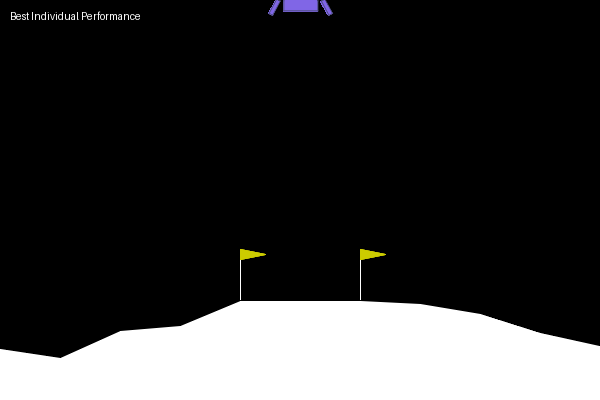

In [34]:
from IPython.display import Image, display

display(Image(filename=gif_path))